In [27]:
import numpy as np
import pandas as pd
from numpy.random import random as rand
from tqdm import tqdm 
import random
import math
import matplotlib as mpl
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
import matplotlib as mpl
import matplotlib.pyplot as plt

# 导入数据

In [49]:
#澳大利亚数据集，参数为15个（含常数项）
ss = StandardScaler()
b = np.ones(data.shape[0])
data = np.loadtxt(r'dataset/australian.dat')
ones=np.ones(data.shape[0])
data = np.column_stack((ones,data))
for i in range(data.shape[0]):
    if data[:,-1][i]==0:
        data[:,-1][i]=-1
X_test=data[-600:,:-1]
y_test=data[-600:, -1]
X=data[:-600,:-1]
y=data[:-600:, -1]
X=ss.fit_transform(X)
X_test=ss.fit_transform(X_test)

# 神经网络

In [29]:
#定义激活函数,函数暂定
def fp(x,p=5):
    exp1=4*p-2;exp2=1/(4*p-2)
    return x/(0.000001+(1+x**(exp1))**exp2)

In [30]:
#定义神经网络损失函数，输出为目标函数值以及对应的隐藏层偏执向量
#只能对一个个种群单独计算
def function1(W,C=0.1):#含有权重
    H_in=X.dot(W)
    H_out=fp(H_in)    
    HH= H_out.T.dot(H_out); HT = H_out.T.dot(y)
    b=np.linalg.pinv(HH+np.identity(W.shape[1])/C).dot(HT)
    sum2=0
    for j in range(X.shape[0]):
        sum1=0
        for i in range(W.shape[1]):#默认权重从w0常数项开始，包括了偏执b
            sum1+=b[i]*fp(W[:,i].dot(X[j]))
        error=sum1-y[j]
        sum2+=(error)**2
    F=np.sqrt(sum2/X.shape[0])
#     print(b,'--------')
    return (F,b)

In [31]:
#用于function1的预测函数
def predict1(W,b,C=0.1):#含有权重
    H_in=X_test.dot(W)
    fx=H_in.dot(b)
    return fx

# 遗传算法

In [47]:
class GA:
    def __init__(self,objfunction,gen,population_size,hidden,weight,chromosome_length,max_value,death_rate,pc,pm,lower,upper):#定义初始化
        self.objfunction=objfunction#目标函数，神经网络，接受的矩阵形式，种群数量*隐藏层*权重分布
        self.weight=weight #所求参数的数量
        self.population_size=population_size #种群数量
        self.hidden=hidden#隐藏层数量
        self.cl=chromosome_length#一个参数对应的基因数量
        self.choromosome_length=chromosome_length*hidden*weight #基因的长度，单参数基因长度*隐藏层*权重层        
        self.max_value=max_value#适应度函数参数
        self.death_rate=death_rate#自然淘汰率，这个比率代表了有多少种群要被淘汰
        self.pc=pc#杂交率
        self.pm=pm#变异率
        self.gen=gen#迭代率
        self.lower=lower
        self.upper=upper
        
#     def species_origin(self):#定义population为种群数量*基因长度的矩阵，种群数量*隐藏层*权重分布  
#         self.population=np.random.randint(0,2,size=(self.population_size,
#                                                     self.choromosome_length))#输出种群数量*基因长度
    def species_origin(self):#定义population为种群数量*基因长度的矩阵，种群数量*隐藏层*权重分布  
        population=np.random.randint(0,2,size=(self.population_size,self.choromosome_length))#输出种群数量*基因长度
        return population

    
    def translation(self,population): #定义对一个种群转换为对接神经网络的矩阵，输出为隐藏层*权重分布,       
#         print(po_ne)
        population_3D=population.reshape(self.hidden,self.weight,self.cl)#输出矩阵形式：隐藏层*权重分布*基因向量
        population_2D_decimal=np.zeros((self.hidden,self.weight))
        for j in range(population_3D.shape[0]):#循环每个隐藏层
                for m in range(self.weight):#循环每个权重
#                     if population[-1]==1:
#                          po_ne=-1
#                     else:
#                          po_ne=1
                    total1=0#计算每个权重的大小
                    for n in range(self.cl):#循环每一位基因
                            total1+=population_3D[j][m][n]*(math.pow(2,n))
                    population_2D_decimal[j][m]=total1
        for j in range(population_2D_decimal.shape[0]):
                for m in range(population_2D_decimal.shape[1]):
                    population_2D_decimal[j][m]=self.lower+population_2D_decimal[j][m]*(self.upper-self.lower)*self.max_value/(math.pow(2,self.cl)-1)
#         print(population_2D_decimal)
        return population_2D_decimal
    #经过函数转换后,输出了2D形态poputation[i]的十进制表示，population_2D_decimal矩阵的形式为：隐藏层*权重分布 
      
    def fitnessfunc(self,population,fitness):#fitnessfuc计算population的适应能力,返回一维数据,种群数量*1,
        for i in range(population.shape[0]):#在此处循环每一个种群
               fitness[i]=self.objfunction(self.translation(population[i]).T)[0]#先转换成权重*隐藏层进入神经网络再计算 
#         print('目前一代的性状表现是:','\n',fitness)
        return (fitness)
 
 
    def selection(self,population,fitness,death_rate):
        rat_fitness=np.zeros(fitness.size)#适应度权重初始化
        sum_fitness=np.sum(abs(fitness))#适应度求和
        for i in range(fitness.size):#在每个种群中迭代
            rat_fitness[i]=abs(fitness[i])/sum_fitness#计算每个种群适应度权重
#         print(rat_fitness[i])
        death_idx=np.random.choice(a=population.shape[0], size=math.ceil(death_rate*population.shape[0]), 
                   replace=False, p=rat_fitness)#确定死亡名单，death_idx代表了要删除的序号，权重越高越容易死  
        new_population=np.delete(population,death_idx,0)#删除死亡名单上的种群
#             print(new_population.shape)
        empty_space=population.shape[0]-new_population.shape[0] #计算相比原来种群数量还空缺的位置
        for i in range(empty_space):#依次在空缺位置填补，复制原来筛选下来的种群，确保前后数量一致
            temp=random.randint(0,new_population.shape[0])-1#随机生成复制目标行的序号
#             print(temp)
            new_population=np.row_stack((new_population,new_population[temp]))#添加复制行
        population=new_population#完成自然选择与淘汰
#         print("自然选择了")
        return population

#需要优化##########################################################################       
    def crossover(self,population):
        population_4D=population.reshape(self.population_size,self.hidden,self.weight,self.cl)#输出矩阵形式：种群*隐藏层*权重分布*基因向量
#         pop_len=population.shape[0]
        for i in range(population_4D.shape[0]-1):
            if(random.random()<self.pc):
                for m in range(population_4D.shape[1]):#迭代每一个隐藏层
                    for n in range(population_4D.shape[2]):#迭代每一个权重层
                           cpoint=random.randint(0,population_4D.shape[3])#随机找到权重上一个基因位置
                           temporary1=[]#子代1
                           temporary2=[]#子代2
                           temporary1.extend(population_4D[i][m][n][0:cpoint])#在子代1中放入父代1的一段
                           temporary1.extend(population_4D[i+1][m][n][cpoint:population_4D.shape[3]])#在子代1中放入父代2的一段
                           temporary2.extend(population_4D[i+1][m][n][0:cpoint])#在子代2中放入父代2的一段
                           temporary2.extend(population_4D[i][m][n][cpoint:population_4D.shape[3]])#在子代2中放入父代1的一段
                           population_4D[i][m][n]=np.asarray(temporary1)
                           population_4D[i+1][m][n]=np.asarray(temporary2)#完成染色体交换
        population_4D.reshape(self.population_size,self.choromosome_length)
#         print("杂交了")
        return population
            
    def mutation(self,population):
         px=population.shape[0]
         py=population.shape[1]
         for i in range(px):#在种群中迭代
             if(random.random()<self.pm):#随机生成一个数和变异率比较，如果比变异率还小的话进行以下操作
                for j in range(self.weight*self.hidden):#g根据基因的长短进行变异的次数
                        mpoint=random.randint(0,py-1)#在基因的某个位置生成一个变异点
                        if(population[i][mpoint]==1):#进行1到0的变换或0到1的变换
                           population[i][mpoint]=0
                        else:
                           population[i][mpoint]=1
#          print("变异了")
         return population
 
#     def b2d(self,best_individual):
#         total=0
#         b=len(best_individual)
#         for i in range(b):
#             total=total+best_individual[i]*math.pow(2,i)
#         total=total*self.max_value/(math.pow(2,self.choromosome_length)-10)
#         return total
  
    def best(self,population,fitness,best_individual,best_fitness):
        px=population.shape[0]
        best_fitness=fitness[0] #先定义bestfitness作对比
#         print(bestfitness)
        for i in range(1,px):
            if fitness[i]<best_fitness: #同时满足适应度>0并且要比目前最好的还要好
                best_fitness=fitness[i]#更新最优秀的适应度
                best_individual=population[i]#更新最优秀的基因
        return (best_individual,best_fitness)
 
    def main(self):
        fitness=np.zeros(self.population_size)#随机初始化适应度，初始化
        population = self.species_origin()#初始化种群，初始化
        fitness=self.fitnessfunc(population,fitness)#更新初始化适应度以及隐藏层偏执
        best_b=np.zeros(population.shape[1])#创建最佳隐藏层偏执列表，初始化
        best_individual=np.random.randint(0,2,self.choromosome_length)#存储最优秀的种群基因，初始化
        best_hidden_weight=np.zeros((self.hidden,self.weight))#存储最优秀的2D性状，隐藏层*权重分布，初始化
        best_fitness=10000000#存储最优秀个体的适应度
        best_fitness_note=np.zeros(self.gen)#记录每一次迭代的最优秀个体适应度
        print('====================物种初始化结束,开始进化=====================')
        for i in tqdm(range(self.gen)): 
#                 print('==============第',i+1,'轮重新计算适应度==============')               
                population=self.selection(population,fitness,self.death_rate)#进行自然选择淘汰
                population=self.crossover(population)#进行基因杂交
                population=self.mutation(population)#进行基因突变
                fitness=self.fitnessfunc(population,fitness)#更新初始化适应度以及隐藏层偏执
                best_individual,best_fitness=self.best(population,fitness,best_individual,best_fitness)#寻找最佳
                best_hidden_weight=self.translation(best_individual)#更新最优秀的2D性状，隐藏层*权重分布
                best_fitness_note[i]=best_fitness#记录最优适应度记录                        
                if i%10==0:
                    best_b=self.objfunction(best_hidden_weight.T)[1]
                    predict=predict1(best_hidden_weight.T,best_b)
                    for i in range(predict.size):
                        if predict[i]>0:
                            predict[i]=1
                        else:
                            predict[i]=-1
                    sum=0
                    for i in range(predict.size):
                        if predict[i]==y_test[i]:
                            sum+=1
                    rate=sum/len(predict)
                    print('预测成功率:',rate)
#                     print('目前一代的最优性状2D表现是:','\n',best_hidden_weight)
                    print('第',i+1,'轮中最好的适应度是:',best_fitness)
#                     print('目前一代的最适应表现是:','\n',fitness)
                    print('========================继续进化=========================')
        best_individual,best_fitness=self.best(population,fitness,best_individual,best_fitness)#更新最优秀的适应度和基因
        best_fitness_note[-1]=best_fitness#记录最优适应度记录
        best_hidden_weight=self.translation(best_individual).T#更新最优秀的2D性状，隐藏层*权重分布
        best_b=self.objfunction(best_hidden_weight)[1]#更新最优秀的隐藏层偏执
        print('最好的隐藏层矩阵是:',best_hidden_weight)
        print('最好的隐藏层偏执是:',best_b)
        print('最好的适应度是:',best_fitness)
        plt.plot(best_fitness_note)
        print('最终预测成功率:',rate)
        print('=========================END=======================')
        return (best_hidden_weight,best_b)

# 学习与预测

  0%|          | 0/500 [00:00<?, ?it/s]

====================物种初始化结束,开始进化=====================


  0%|          | 1/500 [00:03<29:07,  3.50s/it]

预测成功率: 0.8466666666666667
第 600 轮中最好的适应度是: 0.6027761411333724
========================继续进化=========================


  2%|▏         | 11/500 [00:37<28:19,  3.48s/it]

预测成功率: 0.77
第 600 轮中最好的适应度是: 0.5566451235598915
========================继续进化=========================


  4%|▍         | 21/500 [01:17<33:52,  4.24s/it]

预测成功率: 0.8
第 600 轮中最好的适应度是: 0.5427907824102666
========================继续进化=========================


  6%|▌         | 31/500 [01:56<31:04,  3.98s/it]

预测成功率: 0.8233333333333334
第 600 轮中最好的适应度是: 0.5515711852405107
========================继续进化=========================


  8%|▊         | 41/500 [03:04<53:57,  7.05s/it]

预测成功率: 0.8516666666666667
第 600 轮中最好的适应度是: 0.5521138865380056
========================继续进化=========================


 10%|█         | 51/500 [03:54<39:29,  5.28s/it]

预测成功率: 0.85
第 600 轮中最好的适应度是: 0.4774297466147
========================继续进化=========================


 12%|█▏        | 61/500 [05:05<49:54,  6.82s/it]

预测成功率: 0.8133333333333334
第 600 轮中最好的适应度是: 0.4516418630961711
========================继续进化=========================


 14%|█▍        | 71/500 [06:06<43:09,  6.04s/it]

预测成功率: 0.8283333333333334
第 600 轮中最好的适应度是: 0.5062093061810962
========================继续进化=========================


 16%|█▌        | 81/500 [07:09<42:30,  6.09s/it]

预测成功率: 0.815
第 600 轮中最好的适应度是: 0.48271690926310507
========================继续进化=========================


 18%|█▊        | 91/500 [08:08<40:23,  5.93s/it]

预测成功率: 0.8166666666666667
第 600 轮中最好的适应度是: 0.48494963321375645
========================继续进化=========================


 20%|██        | 101/500 [09:06<38:51,  5.84s/it]

预测成功率: 0.8266666666666667
第 600 轮中最好的适应度是: 0.48260024135797974
========================继续进化=========================


 22%|██▏       | 111/500 [10:04<36:49,  5.68s/it]

预测成功率: 0.8283333333333334
第 600 轮中最好的适应度是: 0.5009132229340308
========================继续进化=========================


 24%|██▍       | 121/500 [11:02<36:20,  5.75s/it]

预测成功率: 0.8116666666666666
第 600 轮中最好的适应度是: 0.4499949698640168
========================继续进化=========================


 26%|██▌       | 131/500 [11:57<34:10,  5.56s/it]

预测成功率: 0.8366666666666667
第 600 轮中最好的适应度是: 0.44630365865907246
========================继续进化=========================


 28%|██▊       | 141/500 [12:53<33:05,  5.53s/it]

预测成功率: 0.82
第 600 轮中最好的适应度是: 0.405834944918911
========================继续进化=========================


 30%|███       | 151/500 [13:49<33:36,  5.78s/it]

预测成功率: 0.815
第 600 轮中最好的适应度是: 0.4133753170577522
========================继续进化=========================


 32%|███▏      | 161/500 [14:47<32:22,  5.73s/it]

预测成功率: 0.8083333333333333
第 600 轮中最好的适应度是: 0.4168450980837628
========================继续进化=========================


 34%|███▍      | 171/500 [15:42<30:32,  5.57s/it]

预测成功率: 0.8216666666666667
第 600 轮中最好的适应度是: 0.41496407826858384
========================继续进化=========================


 36%|███▌      | 181/500 [16:37<29:20,  5.52s/it]

预测成功率: 0.8083333333333333
第 600 轮中最好的适应度是: 0.39112221975758565
========================继续进化=========================


 38%|███▊      | 191/500 [17:34<28:45,  5.58s/it]

预测成功率: 0.815
第 600 轮中最好的适应度是: 0.40774431925698196
========================继续进化=========================


 40%|████      | 201/500 [18:29<27:40,  5.56s/it]

预测成功率: 0.8183333333333334
第 600 轮中最好的适应度是: 0.40327388658690905
========================继续进化=========================


 42%|████▏     | 211/500 [19:25<26:46,  5.56s/it]

预测成功率: 0.805
第 600 轮中最好的适应度是: 0.40989525685638395
========================继续进化=========================


 44%|████▍     | 221/500 [20:23<27:35,  5.93s/it]

预测成功率: 0.815
第 600 轮中最好的适应度是: 0.3944950317502578
========================继续进化=========================


 46%|████▌     | 231/500 [21:19<24:56,  5.56s/it]

预测成功率: 0.82
第 600 轮中最好的适应度是: 0.39962462685610317
========================继续进化=========================


 48%|████▊     | 241/500 [22:14<23:41,  5.49s/it]

预测成功率: 0.8183333333333334
第 600 轮中最好的适应度是: 0.37975183006192526
========================继续进化=========================


 50%|█████     | 251/500 [23:13<25:28,  6.14s/it]

预测成功率: 0.8016666666666666
第 600 轮中最好的适应度是: 0.38720482470835477
========================继续进化=========================


 52%|█████▏    | 261/500 [24:12<22:33,  5.66s/it]

预测成功率: 0.805
第 600 轮中最好的适应度是: 0.3691306615384709
========================继续进化=========================


 54%|█████▍    | 271/500 [25:09<21:23,  5.60s/it]

预测成功率: 0.8233333333333334
第 600 轮中最好的适应度是: 0.37349849202128144
========================继续进化=========================


 56%|█████▌    | 281/500 [26:04<20:16,  5.56s/it]

预测成功率: 0.815
第 600 轮中最好的适应度是: 0.358452518875818
========================继续进化=========================


 58%|█████▊    | 291/500 [27:01<19:47,  5.68s/it]

预测成功率: 0.8
第 600 轮中最好的适应度是: 0.36102129803366456
========================继续进化=========================


 60%|██████    | 301/500 [27:57<18:24,  5.55s/it]

预测成功率: 0.8033333333333333
第 600 轮中最好的适应度是: 0.34338084331787444
========================继续进化=========================


 62%|██████▏   | 311/500 [28:52<17:32,  5.57s/it]

预测成功率: 0.8083333333333333
第 600 轮中最好的适应度是: 0.35292783464972743
========================继续进化=========================


 64%|██████▍   | 321/500 [29:49<17:39,  5.92s/it]

预测成功率: 0.7866666666666666
第 600 轮中最好的适应度是: 0.36284741774374246
========================继续进化=========================


 66%|██████▌   | 331/500 [30:44<15:35,  5.53s/it]

预测成功率: 0.8166666666666667
第 600 轮中最好的适应度是: 0.3621758391563183
========================继续进化=========================


 68%|██████▊   | 341/500 [31:40<14:34,  5.50s/it]

预测成功率: 0.8166666666666667
第 600 轮中最好的适应度是: 0.37156213541661964
========================继续进化=========================


 70%|███████   | 351/500 [32:36<13:58,  5.63s/it]

预测成功率: 0.8133333333333334
第 600 轮中最好的适应度是: 0.363199411433176
========================继续进化=========================


 72%|███████▏  | 361/500 [33:30<12:40,  5.47s/it]

预测成功率: 0.8283333333333334
第 600 轮中最好的适应度是: 0.3574188851666359
========================继续进化=========================


 74%|███████▍  | 371/500 [34:25<11:50,  5.50s/it]

预测成功率: 0.8133333333333334
第 600 轮中最好的适应度是: 0.35365373225624713
========================继续进化=========================


 76%|███████▌  | 381/500 [35:22<11:09,  5.63s/it]

预测成功率: 0.8116666666666666
第 600 轮中最好的适应度是: 0.35496265766606433
========================继续进化=========================


 78%|███████▊  | 391/500 [36:18<10:10,  5.60s/it]

预测成功率: 0.8266666666666667
第 600 轮中最好的适应度是: 0.34664571615714573
========================继续进化=========================


 80%|████████  | 401/500 [37:16<09:39,  5.86s/it]

预测成功率: 0.8233333333333334
第 600 轮中最好的适应度是: 0.3501643324924467
========================继续进化=========================


 82%|████████▏ | 411/500 [38:03<05:54,  3.98s/it]

预测成功率: 0.8316666666666667
第 600 轮中最好的适应度是: 0.35121839911729086
========================继续进化=========================


 84%|████████▍ | 421/500 [38:43<05:15,  3.99s/it]

预测成功率: 0.8233333333333334
第 600 轮中最好的适应度是: 0.3473842734459751
========================继续进化=========================


 86%|████████▌ | 431/500 [39:18<03:57,  3.44s/it]

预测成功率: 0.825
第 600 轮中最好的适应度是: 0.34553697197376043
========================继续进化=========================


 88%|████████▊ | 441/500 [39:51<03:17,  3.34s/it]

预测成功率: 0.8233333333333334
第 600 轮中最好的适应度是: 0.33950745892406275
========================继续进化=========================


 90%|█████████ | 451/500 [40:25<02:43,  3.33s/it]

预测成功率: 0.8216666666666667
第 600 轮中最好的适应度是: 0.3366092994553059
========================继续进化=========================


 92%|█████████▏| 461/500 [40:58<02:09,  3.33s/it]

预测成功率: 0.8183333333333334
第 600 轮中最好的适应度是: 0.34839104074600913
========================继续进化=========================


 94%|█████████▍| 471/500 [41:31<01:36,  3.32s/it]

预测成功率: 0.825
第 600 轮中最好的适应度是: 0.3467898969662137
========================继续进化=========================


 96%|█████████▌| 481/500 [42:04<01:03,  3.33s/it]

预测成功率: 0.83
第 600 轮中最好的适应度是: 0.3446958168823144
========================继续进化=========================


 98%|█████████▊| 491/500 [42:38<00:30,  3.34s/it]

预测成功率: 0.8116666666666666
第 600 轮中最好的适应度是: 0.34510230950442705
========================继续进化=========================


100%|██████████| 500/500 [43:08<00:00,  5.18s/it]

最好的隐藏层矩阵是: [[ 2.64711632e+00  3.63636364e-01 -3.96089932e+00 -2.81915934e+00
   9.34506354e-01 -3.17888563e+00]
 [ 1.25513196e+00  2.45161290e+00 -8.17204301e-01  3.31964809e+00
   6.45161290e-01  3.69501466e+00]
 [-3.20234604e+00 -2.04496579e+00 -3.16324536e+00 -3.44477028e+00
   2.63147605e+00  1.90420332e+00]
 [ 2.99902248e+00  2.51417400e+00 -9.18866080e-01  3.94916911e-01
  -3.03812317e+00 -3.80449658e+00]
 [-2.35777126e+00  3.76539589e+00  5.90420332e-01  1.97458456e+00
   1.60703812e+00 -1.60312805e-01]
 [-2.72531769e+00  3.82795699e+00  3.11632454e+00 -2.89736070e+00
  -2.16226784e+00  1.78690127e+00]
 [ 2.85434995e-01  7.42913001e-02 -2.92082111e+00 -2.37341153e+00
  -5.51319648e-01 -3.91006843e-03]
 [ 2.27956989e+00  4.57478006e-01  3.49951124e+00 -8.79765396e-01
  -3.87487781e+00  2.90518084e+00]
 [-3.96871945e+00  2.93646139e+00  3.46823069e+00 -3.54643206e+00
  -2.31085044e+00 -2.41251222e+00]
 [ 3.91006843e-03 -1.83382209e+00  1.16129032e+00 -2.70967742e+00
   3.47605083e

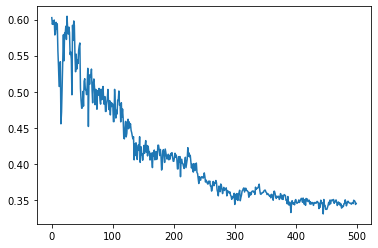

In [48]:

# (self,population_size,hidden,weight,chromosome_length,max_value,pc,pm):
ga=GA(objfunction=function1,gen=500,population_size=500,hidden=6,weight=15,chromosome_length=10,
      max_value=1,death_rate=0.75,pc=0.75,pm=0.02,lower=-4,upper=4)
W,b=ga.main()
